<a href="https://colab.research.google.com/github/antonium85/stock-trading-analysis/blob/main/stock_sma50vs100_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.1 MB/s 
     |████████████████████████████████| 83 kB 816 kB/s 
     |████████████████████████████████| 127 kB 45.0 MB/s 
     |████████████████████████████████| 112 kB 48.8 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=8d0e47658158e62a19aebde511f2179cb2799a2ef08bfa99153020f07987794b
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=5d326cd435a2741cbc4f2d947403003eec2a5395dfa5183f2cff776681ce4d48
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=be067b06de42c11722f43ea0b41330dfd4ba96a71a6df47b92123

In [2]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=0cf1c88448b631012ace89a95961f8155bcc5985437e974b3ee0c6b623edb1cb
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [3]:
import pandas as pd
import ta
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import time

In [33]:
def get_historical_datas(ticker, interval):
  if interval == '1d':
    end_date = datetime.today()
  elif interval == '1wk':
    end_date = datetime.today() #- timedelta(1)
  start_date = end_date - timedelta(365*10)

  #print("End date = ", end_date.strftime('%d-%m-%Y'))
  #print("Start date = ", start_date.strftime('%d-%m-%Y'))

  # replace ^FCHI (CAC40) by what you want AMZN, GOOG, META ...
  output = get_data(ticker, start_date=start_date.strftime('%d/%m/%Y'), end_date=end_date.strftime('%d/%m/%Y'), index_as_date = True, interval=interval)

  #del(output)
  output['close'] = pd.to_numeric(output['close'])
  output['high'] = pd.to_numeric(output['high'])
  output['low'] = pd.to_numeric(output['low'])
  output['open'] = pd.to_numeric(output['open'])

  output['SMA25'] = ta.trend.sma_indicator(output['close'], 25)
  output['SMA50'] = ta.trend.sma_indicator(output['close'], 50)
  output['SMA100'] = ta.trend.sma_indicator(output['close'], 100)
  output['SMA99'] = ta.trend.sma_indicator(output['close'], 99)
  output['SMA200'] = ta.trend.sma_indicator(output['close'], 200)

  return output

In [36]:
#print("End date = ", end_date.strftime('%d-%m-%Y'))
#print("Start date = ", start_date.strftime('%d-%m-%Y'))

ticker_list = ["NFLX","PYPL","TSLA","AMZN","AAPL","GOOG","META","MSFT","MNTV","ADBE","NVDA","V"] 

historical_datas = {}
weekly_historical_datas = {}
for ticker in ticker_list:
  print(ticker)
  
  historical_datas[ticker] = get_historical_datas(ticker, '1d')
  weekly_historical_datas[ticker] = get_historical_datas(ticker, '1wk')

NFLX
PYPL
TSLA
AMZN
AAPL
GOOG
META
MSFT
MNTV
ADBE
NVDA
V


# SMA Trading Algo
*   Cross SMA50 vs SMA100 : work well for TSLA, NFLX, PYPL
*   Cross SMA100 vs SMA200 : work well for WLN.PA, CDI.PA

In [37]:
dt = pd.DataFrame(columns = ['last action', 'date', 'traded price','actual price','wallet'])
result = dict()
lastAction=''
lastIndex = ''
lastPrice = ''
for ticker in ticker_list:
  usd = 1000
  share = 0

  df = historical_datas[ticker].copy()
  for index, row in df.iterrows():
    if row['SMA50'] > row['SMA100'] and usd > 10:
      share = usd / df['close'][index] 
      usd = 0
      
      lastIndex = index
      lastAction = 'buy'
      lastPrice = row['close']

    if row['SMA50'] < row['SMA100'] and share > 1:
      usd = share * df['close'][index]
      share = 0
      
      lastIndex = index
      lastAction = 'sell'
      lastPrice = row['close']

  finalResult = usd + share * df['close'].iloc[-1]
  result[ticker] = finalResult

  myrow = pd.DataFrame({'last action':lastAction,'date':lastIndex,'traded price':lastPrice,'actual price':df['close'].iloc[-1],'wallet':finalResult},index=[ticker])
  dt = pd.concat([dt,myrow])
  #print("Final result for ",ticker,' : ',finalResult,'$')
  #print('Ticker ',ticker,' last action ',lastAction,' date :',lastIndex,' price : ',lastPrice)

dt

,last action,date,traded price,actual price,wallet
NFLX,buy,2022-08-31,223.559998,289.570007,9957.236356
PYPL,buy,2022-09-01,92.660004,83.940002,2328.469424
TSLA,buy,2022-09-01,277.160004,214.440002,62948.516613
AMZN,buy,2022-08-30,128.729996,119.320000,5007.862116
AAPL,buy,2022-08-26,163.619995,147.270004,4891.445951
GOOG,sell,2022-09-19,103.849998,101.480003,2126.117936
META,sell,2021-10-29,323.570007,130.009995,2659.801357
MSFT,sell,2022-10-11,225.410004,242.119995,4646.571785
MNTV,sell,2022-01-11,19.370001,7.650000,333.327315
ADBE,sell,2022-09-19,296.059998,306.369995,3440.850922


Last price :  289.57000732421875
TENKAN[-1] =  251.23999786376953
KIJUN[-1] =  251.23999786376953
SSA[-1] =  230.91500091552734
SSB[-1] =  210.84500122070312
SMA100[-1] =  217.2258006286621
SMA200[-1] =  278.2114504241943


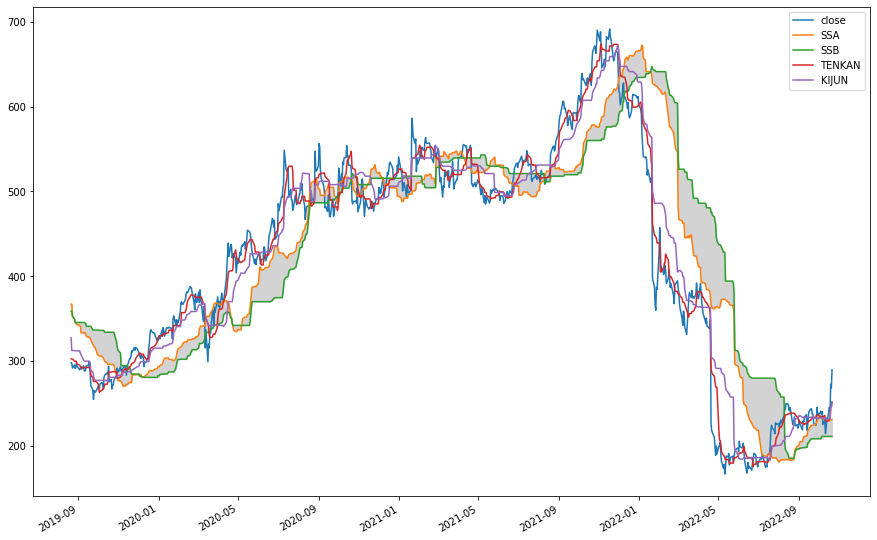

In [6]:
import matplotlib

ticker_test = 'NFLX'

print('Last price : ',historical_datas[ticker_test]['close'].iloc[-1])
print('TENKAN[-1] = ',historical_datas[ticker_test]['TENKAN'].iloc[-1])
print('KIJUN[-1] = ',historical_datas[ticker_test]['KIJUN'].iloc[-1])
print('SSA[-1] = ',historical_datas[ticker_test]['SSA'].iloc[-1])
print('SSB[-1] = ',historical_datas[ticker_test]['SSB'].iloc[-1])
print('SMA100[-1] = ',historical_datas[ticker_test]['SMA100'].iloc[-1])
print('SMA200[-1] = ',historical_datas[ticker_test]['SMA200'].iloc[-1])

#df[['close','SSA','SSB']].iloc[-600:].plot(figsize=(20,10))
tmp = historical_datas[ticker_test][['close','SSA','SSB','TENKAN','KIJUN']].tail(800)
a1 = tmp.plot(figsize=(15,10))
a1.fill_between(tmp.index, tmp.SSA, tmp.SSB,color='lightgrey')